# Tutorial 1: Gaze in Ego-Exo4D dataset

In [1]:
# TODO: Done smaller chunks and cells. 
# TODO: Done remove extra codes that are not necessary
# TODO: having more introduction text in the sessions, more tutorial style
# can benefit users that need to use eye gaze for other projects.
# TODO: google how to embed rerun in jupyter notebook, and show interative output "rerun" when exported in html. otherwise use matplotlib. interactive is better.

In this tutorial, we provide an introduction of the gaze data in Ego-Exo4D dataset, and a step-by-step guide on how to project 3D eye gaze to 2D in Egocentric/Exocentric view. 

Eye gaze is one of the 3D spatial signals provided by Ego-Exo4D dataset, which is pre-computed by Project Aria’s machine perception service (MPS). The gaze direction of the user is estimated as a single outward-facing ray anchored in-between the wearer’s eyes. Left and right eye gaze directions (yaw values) along with the depth at which these gaze directions intersect (translation values) are provided in the dataset. The convergence points and distances are derived from the predicted gaze directions. The combined direction’s yaw is used to populate the yaw field of the EyeGaze object for backwards compatibility. The pitch is common to left, right and combined gaze directions.

<center><img src="https://facebookresearch.github.io/projectaria_tools/img/data_formats/eye_gaze_032024_model.png" width=400 height=400 /></center>

Eye gaze data is located in each captures' or takes' eye_gaze folder. You can determine if a take or capture has eye gaze data by using `has_gaze` for a capture in <b>captures.json</b> and `has_trimmed_eye_gaze` for a take in <b>takes.json</b>. If eye gaze is available for the take, it is trimmed (cropped in time) with respect to that take. You will find three Eye Gaze MPS file outputs under the take folder: 
- `summary.json` - high level report on MPS eye gaze generation
- `general_eye_gaze.csv` - based on the standard eye gaze configuration
- `personalized_eye_gaze.csv` - eye gaze data based on the calibration data collected in the recording, please check <a href="https://facebookresearch.github.io/projectaria_tools/docs/ARK/mps/eye_gaze_calibration">in-session Eye Gaze Calibration</a>
- `general_eye_gaze_2d.csv`
- `personalized_eye_gaze_2d.csv`

### Prerequisites and Imports

Before we get started, we need to install necessary libraries. We will install the Python Package for Project Aria Tools. Please check <a href="https://facebookresearch.github.io/projectaria_tools/docs/data_utilities/installation/installation_python">Installation guide</a> for detailed instructions. We also need to install the rerun library for logging and data visualization. 

**Note:** Instead of using `notebook_show()`, we are showing the rerun logs in videos format. We also provide the exported rerun recordings in `*.rrd` format, which you can view by going to the <a href="https://app.rerun.io/version/0.19.0/index.html">rerun viewer</a> and load the recording. Otherwise, you can also uncomment the `rr.notebook_show()` when you are running the code to show the output in your jupyter notebook.

```
pip install rerun-notebook
pip install rerun-sdk
pip install rerun-sdk[notebook]

cd ~/projectaria_tools_python_env # Replace with your projectaria_tools_python_env folder
python3 -m pip install --upgrade pip
python3 -m pip install projectaria-tools'[all]'
```

Then we import some logging functions that we will use all across the tutorial. 

In [56]:
RERUN_NOTEBOOK_ASSET="inline"
import rerun as rr
import numpy as np

from tqdm import tqdm
from IPython.display import HTML, Video

import os
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from moviepy.editor import *
from IPython.display import Video
import av
import cv2

# project Aria tools
from projectaria_tools.core.calibration import CameraCalibration, DeviceCalibration
from projectaria_tools.core.sophus import SE3
from projectaria_tools.core import mps
from projectaria_tools.core.mps.utils import get_gaze_vector_reprojection
from projectaria_tools.core import data_provider
from projectaria_tools.utils.rerun_helpers import AriaGlassesOutline, ToTransform3D
from projectaria_tools.core import mps
from projectaria_tools.core.stream_id import StreamId
from projectaria_tools.core.sensor_data import TimeDomain, TimeQueryOptions
from projectaria_tools.core.calibration import CameraCalibration, KANNALA_BRANDT_K3
from projectaria_tools.core import data_provider

# logging functions
def log_aria_glasses(
    device_calibration: DeviceCalibration,
    label: str,
    use_cad_calibration: bool = True
) -> None:
    ## Plot Project Aria Glasses outline (as lines)
    aria_glasses_point_outline = AriaGlassesOutline(
        device_calibration, use_cad_calibration
    )
    rr.log(label, rr.LineStrips3D([aria_glasses_point_outline]), timeless=True)

def log_calibration(
    camera_calibration: CameraCalibration,
    label: str
) -> None:
    rr.log(
        label,
        rr.Pinhole(
            resolution=[
                camera_calibration.get_image_size()[0],
                camera_calibration.get_image_size()[1],
            ],
            focal_length=float(
                camera_calibration.get_focal_lengths()[0]
            ),
        ),
        timeless=True,
    )

def log_pose(
    pose: SE3,
    label: str,
    timeless = False
) -> None:
    rr.log(
        label,
        ToTransform3D(pose, False),
        timeless = timeless
    )

def log_image(
    image_array : np.array,
    label: str,
    timeless = False
) -> None:
    rr.log(label, rr.DisconnectedSpace())
    rr.log(label, rr.Image(image_array), timeless = timeless)

def log_point_cloud(
    point_positions : np.array,
    label: str,
    timeless: bool = True) -> None:
    rr.log(label,rr.Points3D(point_positions, radii=0.001, colors=[200, 200, 200]), timeless=timeless)

### 2. Load the sample take and its VRS and MPS data

We will load the following take of bike repair as an example. You need to change `ego_exo_root` to the download directory for the Ego-Exo4D dataset.

In [18]:
ego_exo_root = '/datasets01/egoexo4d/v2/' # Replace with your cli's download directory for Ego-Exo4D
take_name = 'cmu_bike01_5'

import os
ego_exo_project_path = os.path.join(ego_exo_root, 'takes', take_name)
print(f'EgoExo Sequence: {ego_exo_project_path}')

if not os.path.exists(ego_exo_project_path):
    print("Please do update your path to a valid EgoExo sequence folder.")

EgoExo Sequence: /datasets01/egoexo4d/v2/takes/cmu_bike01_5


We retrieve the VRS data including device calibration collected by Aria glasses and plot sensors locations, orientations. 
 - VRS: <a href="https://facebookresearch.github.io/vrs/">VRS</a> is the file format used to store the Project Aria Glasses multimodal data. VRS Data is stored Stream and are identified with a unique StreamId. `VrsDataProvider` enables you to list and retrieve all VRS data and calibration data.
 - DeviceCalibration: an interface that can be used to retrieve Intrinsics for Image Stream data (i.e Camera data) - `CameraCalibration` and Extrinsics are defined for all sensors - `SE3`.

Project Aria glasses use 3D Coordinate Frame Conventions. You can find an overview of these conventions <a href="3D Coordinate Frame Conventions">here</a> where Central Pupil Frame (CPF) and 3D Coordinate frame and system conventions are covered. We use the projectaria_tools API for retrieving the DeviceCalibration and the POSE of each sensor. Then we plot those POSE onto the Aria glasses outline. 

First of all, we load the VRS file and create the VRS data provider.

In [19]:
vrs_file_path = os.path.join(ego_exo_project_path, 'aria01.vrs')
print(f"VRS file path: {vrs_file_path}")
assert os.path.exists(vrs_file_path), "We are not finding the required vrs file"

vrs_data_provider = data_provider.create_vrs_data_provider(vrs_file_path)
if not vrs_data_provider:
    print("Couldn't create data vrs_data_provider from vrs file")
    exit(1)

VRS file path: /datasets01/egoexo4d/v2/takes/cmu_bike01_5/aria01.vrs


[ProgressLogger][INFO]: 2024-11-22 00:00:19: Opening /datasets01/egoexo4d/v2/takes/cmu_bike01_5/aria01.vrs...
[MultiRecordFileReader][DEBUG]: Opened file '/datasets01/egoexo4d/v2/takes/cmu_bike01_5/aria01.vrs' and assigned to reader #0
[VrsDataProvider][INFO]: streamId 211-1/camera-et activated
[VrsDataProvider][INFO]: streamId 214-1/camera-rgb activated
[VrsDataProvider][INFO]: streamId 231-1/mic activated
[VrsDataProvider][INFO]: streamId 247-1/baro0 activated
[VrsDataProvider][WARNING]: Unsupported TimeSync mode: APP, ignoring.
[VrsDataProvider][INFO]: Fail to activate streamId 286-1
[VrsDataProvider][INFO]: streamId 1201-1/camera-slam-left activated
[VrsDataProvider][INFO]: streamId 1201-2/camera-slam-right activated
[VrsDataProvider][INFO]: streamId 1202-1/imu-right activated
[VrsDataProvider][INFO]: streamId 1202-2/imu-left activated
[VrsDataProvider][INFO]: streamId 1203-1/mag0 activated


Next, we load the device calibration of the aria glasses, and the pose of the <a href="https://facebookresearch.github.io/projectaria_tools/docs/data_formats/coordinate_convention/3d_coordinate_frame_convention#the-nominal-central-pupil-frame-cpf">central-pupil-frame</a> in the device frame.

In [20]:
device_calibration = vrs_data_provider.get_device_calibration()

log_aria_glasses(device_calibration, "world/device/glasses_outline")

# Plot CPF (Central Pupil Frame coordinate system)
T_device_CPF = device_calibration.get_transform_device_cpf()
log_pose(T_device_CPF, "device/CPF_CentralPupilFrame")

# Plot Project Aria Glasses outline (as lines)
log_aria_glasses(device_calibration, "device/glasses_outline")

We can get RGB and SLAM left and right stream label from a given StreamId.

In [21]:
rgb_stream_id = StreamId("214-1")
slam_left_stream_id = StreamId("1201-1")
slam_right_stream_id = StreamId("1201-2")
rgb_stream_label = vrs_data_provider.get_label_from_stream_id(rgb_stream_id)
slam_left_stream_label = vrs_data_provider.get_label_from_stream_id(slam_left_stream_id)
slam_right_stream_label = vrs_data_provider.get_label_from_stream_id(slam_right_stream_id)

We can further retrieve time domain, and image configurations from the stream. We also initialize a rerun data stack to visualize the streams. 

In [22]:
# Init rerun api
rr.init("Aria Data Provider - Retrieve Image Stream data")
rec = rr.memory_recording()

# Configure option for data retrieval
time_domain = TimeDomain.DEVICE_TIME  # query data based on host time
option = TimeQueryOptions.CLOSEST # get data whose time [in TimeDomain] is CLOSEST to query time

# Retrieve Start and End time for the given Sensor Stream Id
start_time = vrs_data_provider.get_first_time_ns(rgb_stream_id, time_domain)
end_time = vrs_data_provider.get_last_time_ns(rgb_stream_id, time_domain)

# FYI, you can retrieve the Image configuration using the following
image_config = vrs_data_provider.get_image_configuration(rgb_stream_id)
width = image_config.image_width
height = image_config.image_height
print(f"StreamId {rgb_stream_id}, StreamLabel {rgb_stream_label}, ImageSize: {width, height}")

StreamId 214-1, StreamLabel camera-rgb, ImageSize: (1408, 1408)


Now let's visualize the stream from RGB, SLAM left and right using rerun. We sample 10 frames from the whole stream.

In [35]:
sample_count = 40
sample_timestamps = np.linspace(start_time, end_time, sample_count)
for sample in sample_timestamps:

    # Retrieve the RGB image
    image_tuple_rgb = vrs_data_provider.get_image_data_by_time_ns(rgb_stream_id, int(sample), time_domain, option)
    timestamp = image_tuple_rgb[1].capture_timestamp_ns
    
    # Log timestamp as:
    # - device_time (so you can see the effective time between two frames)
    # - timestamp (so you can see the real VRS timestamp as INT value in the Rerun Timeline dropdown)
    rr.set_time_nanos("device_time", timestamp)
    rr.set_time_sequence("timestamp", timestamp)

    log_image(image_tuple_rgb[0].to_numpy_array(), f"vrs/{rgb_stream_label}")

    # Retrieving the SLAM images
    image_tuple_slam_left = vrs_data_provider.get_image_data_by_time_ns(slam_left_stream_id, int(sample), time_domain, option)
    log_image(image_tuple_slam_left[0].to_numpy_array(), f"vrs/{slam_left_stream_label}")

    image_tuple_slam_right = vrs_data_provider.get_image_data_by_time_ns(slam_right_stream_id, int(sample), time_domain, option)
    log_image(image_tuple_slam_right[0].to_numpy_array(), f"vrs/{slam_right_stream_label}")

# Showing the rerun window
#rr.notebook_show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 47.46it/s]


Now we show the videos from RGB camera and SLAMs.

In [70]:
import ipywidgets as widgets 
from IPython.display import display 
display(widgets.Video.from_file('rgb_slam_video.mov', play=True, width=600, height=600))

Video(value=b'\x00\x00\x00\x14ftypqt  \x00\x00\x00\x00qt  \x00\x00\x00\x08wide\x03\x11\xe85mdat\x00\x00\x00\x0…

### 3. Projecting eye gaze from 3D to 2D in Egocentric View (CPF frame)

Here we show how to project eye gaze data from egocentric view. Eye gaze data is represented as a 3D ray with depth (showing the point of user focus). The eye gaze ray starts from the Central Pupil Frame(CPF). The reprojection of eye gaze ray in any Aria Image Stream (RGB, SLAMs) includes the following 3 steps:
 1. Use the `VrsDataProvider` to retrieve the RGB stream at a given timestamp
 2. Use the `MpsDataProvider` to retrieve if an EyeGaze file is available and to retrieve EyeGaze data at a given timestamp
 3. Compute the corresponding 3D eye gaze vector and retrieve its depth

First, we initialize a rerun data stack for logging and visualization. We use the starting timestamp as an example, but later we will sample 40 timestamps from the duration and visualize their 2D eye gaze in egocentric view.

In [9]:
rr.init("Projecting eye gaze to egocentric view")
#rec = rr.memory_recording()
rr.log("world", rr.ViewCoordinates.RIGHT_HAND_Z_UP, timeless=True)

## Configure the MpsDataProvider (interface used to retrieve Trajectory data)
mps_data_paths_provider = mps.MpsDataPathsProvider(ego_exo_project_path)
mps_data_paths = mps_data_paths_provider.get_data_paths()
mps_data_provider = mps.MpsDataProvider(mps_data_paths)

assert mps_data_provider.has_personalized_eyegaze(), "The sequence does not have Eye Gaze data"

# Log Glasses & calibration linked to the image we want to show
log_aria_glasses(device_calibration, "device/glasses_outline")
rgb_camera_calibration = device_calibration.get_camera_calib(rgb_stream_label)
log_calibration(rgb_camera_calibration, f"world/device/{rgb_stream_label}")

[MpsDataPathsProvider][WARNING]: Hand tracking folder (/datasets01/egoexo4d/v2/takes/cmu_bike01_5/hand_tracking) does not exist in MPS root folder, not loading wrist and palm poses.


Eye gaze data is independent of the Device pose. To display the eye gaze ray, we need to apply the right relative transform Device_to_CPF.

We first take the starting timestamp as an example, and provide a step-by-step guide of how to retrieve the eye gaze data at this timestamp. Next we sample 40 timestamps throughout the whole duration, and visualize the eye gaze data at all the sampled timestamp.

To begin this process, we take the start timestamp, and get the image data at the given timestamp. 

In [10]:
sampled_timestamp = start_time
image_tuple = vrs_data_provider.get_image_data_by_time_ns(rgb_stream_id, int(sampled_timestamp), time_domain, option)
timestamp = image_tuple[1].capture_timestamp_ns
log_image(image_tuple_rgb[0].to_numpy_array(), f"device/{rgb_stream_label}")

To visualize eye_gaze ray at each timestamp, we follow the 3 steps below:
1. retrieve the eye_gaze data vector with the `mps_data_provider`.

In [11]:
eye_gaze = mps_data_provider.get_personalized_eyegaze(timestamp)

Loaded #EyeGazes: 1555


2. compute the corresponding 3D vector and retrieve its depth. Depth is set to default of 1.0 if eye gaze data doesn't provide depth. We use a proxy of 30cm to better display things in context of each other. Eye_gaze vector is transformed to CPF coordinate system for visualization and 3D ray logging.

In [12]:
depth_m = 0.1
gaze_vector_in_cpf = mps.get_eyegaze_point_at_depth(eye_gaze.yaw, eye_gaze.pitch, depth_m)
gaze_vector_in_cpf = np.nan_to_num(gaze_vector_in_cpf)
# Move EyeGaze vector to CPF coordinate system for visualization and log a 3D ray
rr.log(
    "device/eye-gaze",
    rr.Arrows3D(
        origins=[T_device_CPF @ [0, 0, 0]],
        vectors=[T_device_CPF @ gaze_vector_in_cpf],
        colors=[[255, 0, 255]],
    ),
)

3. reproject the eye_gaze vector at Depth X on a given image (using Calibration data)

In [36]:
depth_m = eye_gaze.depth or 1.0
gaze_projection = get_gaze_vector_reprojection(
    eye_gaze,
    rgb_stream_label,
    device_calibration,
    rgb_camera_calibration,
    depth_m,
)
if gaze_projection is not None:
    rr.log(
        f"device/{rgb_stream_label}/eye-gaze_projection",
        rr.Points2D(gaze_projection, radii=30, colors=[0,255,0]),
    )

Now we aggregate the above steps together, and sample 40 timestamps form the whole duration and visualize the corresponding eye gaze data. 

In [37]:
rr.init("Eye Gaze - CPF - Image Reprojection")
#rr.save('./eye_gaze.rrd')
rec = rr.memory_recording()
rr.log("world", rr.ViewCoordinates.RIGHT_HAND_Z_UP, timeless=True)

## Configure the MpsDataProvider (interface used to retrieve Trajectory data)
mps_data_paths_provider = mps.MpsDataPathsProvider(ego_exo_project_path)
mps_data_paths = mps_data_paths_provider.get_data_paths()
mps_data_provider = mps.MpsDataProvider(mps_data_paths)

assert mps_data_provider.has_personalized_eyegaze(), "The sequence does not have Eye Gaze data"

# Log Glasses & calibration linked to the image we want to show
log_aria_glasses(device_calibration, "device/glasses_outline")
rgb_camera_calibration = device_calibration.get_camera_calib(rgb_stream_label)
log_calibration(rgb_camera_calibration, f"world/device/{rgb_stream_label}")

sample_count = 40
sample_timestamps = np.linspace(start_time, end_time, sample_count)
for sample in sample_timestamps:
    image_tuple = vrs_data_provider.get_image_data_by_time_ns(rgb_stream_id, int(sample), time_domain, option)
    timestamp = image_tuple[1].capture_timestamp_ns
    rr.set_time_nanos("device_time", timestamp)
    rr.set_time_sequence("timestamp", timestamp)
    log_image(image_tuple_rgb[0].to_numpy_array(), f"device/{rgb_stream_label}")

    # 1. Retrieve the eye_gaze data vector for a given timestamp
    eye_gaze = mps_data_provider.get_personalized_eyegaze(timestamp)

    # 2. Compute the corresponding 3D vector and retrieve its depth
    depth_m = 0.1
    gaze_vector_in_cpf = mps.get_eyegaze_point_at_depth(eye_gaze.yaw, eye_gaze.pitch, depth_m)
    gaze_vector_in_cpf = np.nan_to_num(gaze_vector_in_cpf)
    # Move EyeGaze vector to CPF coordinate system for visualization and log a 3D ray
    rr.log(
        "device/eye-gaze",
        rr.Arrows3D(
            origins=[T_device_CPF @ [0, 0, 0]],
            vectors=[T_device_CPF @ gaze_vector_in_cpf],
            colors=[[255, 0, 255]],
        ),
    )

    # 3. Reproject the eyegaze vector at Depth X on a given image (using Calibration data)
    depth_m = eye_gaze.depth or 1.0
    gaze_projection = get_gaze_vector_reprojection(
        eye_gaze,
        rgb_stream_label,
        device_calibration,
        rgb_camera_calibration,
        depth_m,
    )
    if gaze_projection is not None:
        rr.log(
            f"device/{rgb_stream_label}/eye-gaze_projection",
            rr.Points2D(gaze_projection, radii=30, colors=[0,255,0]),
        )
#rr.notebook_show()

[2024-11-22T00:57:42Z WARN  re_sdk::log_sink] Dropping data in MemorySink
[MpsDataPathsProvider][WARNING]: Hand tracking folder (/datasets01/egoexo4d/v2/takes/cmu_bike01_5/hand_tracking) does not exist in MPS root folder, not loading wrist and palm poses.
 30%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 12/40 [00:00<00:00, 55.35it/s]

Loaded #EyeGazes: 1555


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 60.87it/s]


Now we show the output of projecting 3D eye gaze to egocentric view.

In [73]:
import ipywidgets as widgets 
from IPython.display import display 
display(widgets.Video.from_file('egocentric_eye_gaze.mov', play=True, width=600, height=600))

Video(value=b'\x00\x00\x00\x14ftypqt  \x00\x00\x00\x00qt  \x00\x00\x00\x08wide\x02\x9f\xaf\xdbmdat\x00\x00\x00…

### 4. TODO: Projecting eye gaze from 3D to 2D in multiple Exocentric Views

In [39]:
# Create black images representing GoPro images

### 5. Loading pre-computed 2D eye gaze on the egocentric frames

We load the 2D eye gaze file `personalized_eye_gaze_2d.csv`, and store the x and y coordinates into a list of tuples `gaze_2d_coords`.

In [44]:
gaze_2d = pd.read_csv(os.path.join(ego_exo_root, 'takes', take_name, "eye_gaze/personalized_eye_gaze_2d.csv"))
print(gaze_2d)
x_values = gaze_2d['x'].tolist()
y_values = gaze_2d['y'].tolist()
gaze_2d_coords = list(map(lambda x, y: (x, y), x_values, y_values))

      frame_num  tracking_timestamp_us           x           y
0             0              528950878  647.015260  571.732821
1             1              529050862  644.368523  572.805567
2             2              529150846  643.610287  543.872325
3             3              529250830  639.382070  518.885597
4             4              529350814  637.477232  518.928959
...         ...                    ...         ...         ...
1550       1550              683926078  465.794933  555.124614
1551       1551              684026062  491.301091  555.907483
1552       1552              684126046  512.226784  555.796346
1553       1553              684226030  522.740074  578.400592
1554       1554              684326014  553.804559  585.854870

[1555 rows x 4 columns]


We also need to load the egocentric video `aria01_214-1.mp4` from `frame_aligned_videos` under the take folder. Then we extract all the frames from the video and store them in a list `frames` of length `fps/3 * duration`. (We divide the fps to fps/3 here to align with the length of 2D eye gaze data.)

In [45]:
ego_video = os.path.join(ego_exo_root, 'takes', take_name, "frame_aligned_videos", "aria01_214-1.mp4")
clip = VideoFileClip(ego_video) 
num_frames = int(clip.fps * clip.duration)
frames = []
#for t in np.arange(0, float(clip.duration), 1/clip.fps):  
#    frame = clip.get_frame(t)  # Get frame at time 't'
for frame in clip.iter_frames():
    frames.append(frame)
frames = frames[::3]

We can easily visualize the 2D gaze points on the frames. And we concatenate the frames to a video.

In [46]:
frames_with_points = []
for i, frame in enumerate(frames):
    point_x, point_y = gaze_2d_coords[i][0], gaze_2d_coords[i][1]
    img = Image.fromarray(frame)
    # Draw a point on the image
    draw = ImageDraw.Draw(img)
    draw.ellipse((point_x-25, point_y-25, point_x+25, point_y+25), fill=(255, 0, 0))
    # Append the frame with point to the list
    frames_with_points.append(np.array(img))

Now let's show some frames from the egocentric video with the 2D eye gaze visualized on them. The 2D eye gaze location is shown as a red dot.

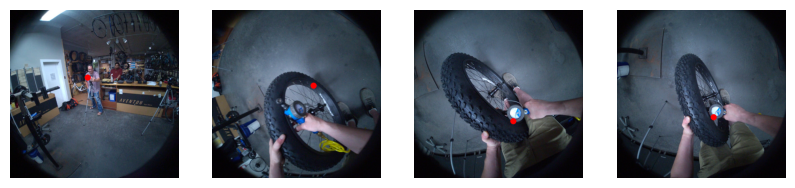

In [47]:
f, axarr = plt.subplots(1,4, figsize=(10, 10))
for i, ax in enumerate(axarr.flat):
    ax.imshow(frames_with_points[i*200], cmap='gray')
    ax.axis('off')

We concatenate the frames into a video. Voila!!

In [72]:
import ipywidgets as widgets 
from IPython.display import display 
display(widgets.Video.from_file('2d_gaze_projection.mp4', play=True, width=600, height=600))

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...', height='600', wid…